In [5]:
import pandas as pd
import numpy as np
import datetime
import vsm
import itertools
import statsmodels.tsa.stattools as smts
import statsmodels
import statsmodels.regression.linear_model
import os
VSM = pd.read_csv('MarketVSM_prototype',index_col=0)


#### Ignore this, just set up code that I'm too lazy to fix in chants.py

In [2]:
def symbol_path(symbol,base_dir = '../data'):
    return os.path.join(base_dir,f'{str(symbol)}.csv')

def get_data(symbols,dates): #dates expects datetime object not str
    df1 = pd.DataFrame(index=dates)
    #if 'SPY' not in symbols:
        #symbols.insert(0,'SPY') # why the zero?
    for symbol in symbols:
        temp = pd.read_csv(symbol_path(symbol),index_col='Date',parse_dates=True,usecols=['Date','Adj Close'],na_values='nan')
        temp = temp.rename(columns={'Adj Close':symbol})
        df1 = df1.join(temp)
    return df1

### Co-integration
I took this function from https://www.programcreek.com/python/example/122726/statsmodels.tsa.stattools.coint

You Pass it a DataFrame of stocks with values and your sig level. Not sure what intercept is. I'm using daily returns from the og stock dataset. It returns any co-integrated pair along with the p value.

In [8]:
def coint(df, intercept = True, sig_level = 0.01):
    """
    Find pairs (of 2 time series) that passes the cointegration test.

    Parameters
    ----------
    df: pandas dataframe
        each column is the time series of a certain stock
    
    intercept: boolean
        if True, OLS and ADF test are done manually
        if False, the coint() function from statsmodels.tsa.stattools, which 
        does not include intercept term while doing OLS regression, is used.
    
    sig_level: if p_value of cointegration test is below this level, then we
        can reject the NULL hypothesis, which says that the two series are not
        cointegrated
    
    Return
    ------
    A list of tuples of the form (name of stock 1, name of stock 2, p_value of
    cointegration test).
    
    """
    cointegrated_pairs = []
    
    stock_names = df.columns.values.tolist()
    N = len(stock_names)
    
    stock_pairs = list(itertools.combinations(stock_names, 2))
    
    for pair in stock_pairs:
        stock_1, stock_2 = pair

        p_value = 0

        if not intercept:
            p_value = smts.coint(df[stock_1].values.astype(float), df[stock_2].values.astype(float), trend='c')[1]
        else:
            Y = df[stock_1].values.astype(float)
            X = df[stock_2].values.astype(float)
            X = statsmodels.tools.tools.add_constant(X)

            model = statsmodels.regression.linear_model.OLS(Y, X)
            results = model.fit()
            intercept, slope = results.params

            p_value = smts.adfuller(results.resid)[1]

        if p_value < sig_level and slope > 0:
            cointegrated_pairs.append(tuple([stock_1, stock_2, p_value]))

    return cointegrated_pairs 

####  Test with generic stocks

In [6]:
start = '2011-01-10'
end = '2011-12-29'
dates = pd.date_range(start,end)
spy = get_data(['SPY'],dates)
spy.index
dates1 = [date for date in dates if date in spy.index]
df = get_data(['GE','SPY','AAPL','GOOG','INTC','UPS','ADP','JNJ','KO','PG','LLY','NKE','V','PEP','AA','MSFT','AMZN','CVX'],dates1)
df.dropna(axis=0,inplace=True)
df

,GE,SPY,AAPL,GOOG,INTC,UPS,ADP,JNJ,KO,PG,LLY,NKE,V,PEP,AA,MSFT,AMZN,CVX
2011-01-10,17.58,123.19,340.99,614.21,19.51,68.51,46.06,58.35,30.22,60.80,31.53,82.10,70.85,62.55,16.19,26.95,184.68,85.52
2011-01-11,17.69,123.63,340.18,616.01,19.85,68.14,46.27,58.45,30.04,60.50,31.92,81.95,70.92,62.82,16.03,26.85,184.34,86.86
2011-01-12,17.73,124.74,342.95,616.87,20.09,68.33,46.87,58.67,30.21,61.37,32.03,81.67,71.64,63.19,15.95,27.27,184.08,87.45
2011-01-13,17.66,124.54,344.20,616.69,20.08,68.61,46.42,59.05,30.38,61.86,31.91,80.53,70.19,63.37,15.46,26.92,185.53,87.19
2011-01-14,17.87,125.44,346.99,624.18,19.88,68.83,46.65,58.71,30.25,61.90,31.92,82.00,70.17,63.24,15.68,27.03,188.75,87.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-22,17.74,124.08,396.85,629.70,23.45,71.39,53.03,63.41,34.11,64.55,40.01,93.85,99.99,64.51,8.82,25.31,179.03,103.73
2011-12-23,17.92,125.19,401.61,633.14,23.82,71.85,53.52,64.19,34.48,65.02,40.18,95.91,101.92,65.03,8.77,25.52,177.28,104.89
2011-12-27,17.70,125.29,404.79,640.25,23.98,71.87,53.63,64.23,34.45,65.14,40.29,96.77,101.35,64.84,8.70,25.53,176.27,105.36
2011-12-28,17.52,123.64,400.92,639.70,23.66,71.12,53.00,63.67,34.27,64.90,39.85,95.44,100.17,64.39,8.44,25.32,173.89,103.39


In [9]:
coint(df)

[]

#### Using nearest neighbors list of stocks in Market VSM

In [10]:
vsm.neighbors('GLW',VSM).head()

GLW     0.000000
AMAT    0.062083
APH     0.062353
MOLX    0.077212
DD      0.090262
dtype: float64

In [11]:
df = get_data(['GLW','AMAT','APH','MOLX','DD'],dates1)
df.dropna(axis=0,inplace=True)
coint(df)

[('GLW', 'AMAT', 0.009758370997646973), ('GLW', 'APH', 0.0003620142437016059)]

#### passing in top 30

In [12]:
symbols = [s for s in vsm.neighbors('GLW',VSM).head(30).index]
df = get_data(symbols,dates1)
df.dropna(axis=0,inplace=True)
df

,GLW,AMAT,APH,MOLX,DD,DOV,JEC,XLNX,NUE,DE,...,KLAC,CSX,TEL,HON,ROP,QLGC,PKI,PPG,GE,CSCO
2011-01-10,18.91,13.14,51.56,22.83,46.29,55.35,45.88,29.01,41.39,81.94,...,36.77,21.81,34.51,51.54,74.43,17.04,25.27,79.06,17.58,20.32
2011-01-11,18.89,13.44,52.04,23.02,46.23,55.72,47.10,29.29,42.30,82.99,...,36.69,21.82,34.50,51.64,74.93,16.96,25.55,78.54,17.69,20.40
2011-01-12,19.32,13.61,52.47,23.56,46.35,56.73,48.68,29.76,42.31,84.72,...,37.10,22.04,34.83,52.32,74.75,17.14,25.48,79.48,17.73,20.64
2011-01-13,19.24,13.59,52.25,23.46,46.63,56.91,48.75,29.66,42.30,86.68,...,37.82,22.22,34.96,52.20,74.61,17.39,25.29,79.03,17.66,20.60
2011-01-14,19.21,14.62,51.91,23.61,47.01,57.42,51.02,30.43,41.81,86.73,...,40.06,22.20,35.20,52.61,74.72,18.03,25.03,79.60,17.87,20.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-22,12.80,10.30,44.76,23.22,44.45,56.66,40.69,31.70,39.02,76.46,...,47.11,20.71,30.65,53.60,87.10,15.02,19.46,80.96,17.74,17.92
2011-12-23,13.14,10.58,45.45,23.65,45.04,57.79,40.89,31.76,39.35,77.37,...,47.47,20.95,30.75,53.93,87.81,15.19,19.65,82.09,17.92,18.25
2011-12-27,12.97,10.59,45.58,23.64,45.10,57.96,41.09,31.70,39.40,77.12,...,47.79,20.86,30.59,53.91,88.03,15.14,19.77,82.53,17.70,18.36
2011-12-28,12.70,10.39,44.98,23.32,44.35,56.68,40.14,31.39,38.84,76.03,...,47.33,20.48,29.96,52.95,86.10,14.79,19.38,81.38,17.52,17.95


In [13]:
print(len(coint(df)))
coint(df)

32


[('GLW', 'AMAT', 0.009758370997646973),
 ('GLW', 'APH', 0.0003620142437016059),
 ('GLW', 'SEE', 0.006024194859819413),
 ('APH', 'WY', 0.0040639259419085446),
 ('APH', 'SEE', 0.004131083058298233),
 ('DOV', 'DDR', 0.006553593233321458),
 ('JEC', 'NUE', 0.0005413585623110746),
 ('JEC', 'QLGC', 0.0007012464697806422),
 ('XLNX', 'HON', 0.006219367028931237),
 ('DE', 'ADM', 0.008588611682326929),
 ('WY', 'SEE', 0.008989646761672156),
 ('NWSA', 'KIM', 0.0005904151066924958),
 ('NWSA', 'ADM', 0.0003037645621365504),
 ('NWSA', 'SWK', 0.0001442762396051067),
 ('NWSA', 'DDR', 0.0003966169157685978),
 ('NWSA', 'EMC', 0.000777948805104541),
 ('NWSA', 'KLAC', 0.00019314720199853822),
 ('NWSA', 'CSX', 0.0007286764785460366),
 ('NWSA', 'TEL', 0.0005127488416676114),
 ('NWSA', 'HON', 0.0001854441931350342),
 ('NWSA', 'ROP', 0.000210969757756384),
 ('NWSA', 'QLGC', 0.0002277812870203335),
 ('NWSA', 'PKI', 0.00022733255331372192),
 ('NWSA', 'PPG', 0.00032229148862319935),
 ('NWSA', 'GE', 0.0003111037329

In [15]:
vsm.neighbors('MRK',VSM).head()

MRK    0.000000
EIX    0.009039
DTE    0.010493
POM    0.011517
SRE    0.012237
dtype: float64

In [14]:
symbols = [s for s in vsm.neighbors('MRK',VSM).head().index]
df = get_data(symbols,dates1)
df.dropna(axis=0,inplace=True)
coint(df)

[('MRK', 'DTE', 0.007401716940714658),
 ('MRK', 'POM', 0.0015850781554905468),
 ('DTE', 'POM', 0.006926944313811)]

In [283]:
symbols = [s for s in vsm.neighbors('MRK',VSM).head(30).index]
df = get_data(symbols,dates1)
df.dropna(axis=0,inplace=True)
pairs2 = coint(df)

In [289]:
print(len(pairs2))
pairs2

44


[('MRK', 'DTE', 0.007401716940714658),
 ('MRK', 'POM', 0.0015850781554905468),
 ('MRK', 'NEE', 4.1466530344783144e-05),
 ('MRK', 'TEG', 0.00016733486172980827),
 ('MRK', 'MKC', 0.0014649207012819654),
 ('MRK', 'NU', 0.0004936831663291519),
 ('MRK', 'LLY', 0.009424086037347287),
 ('MRK', 'CAG', 0.0047849729025376195),
 ('MRK', 'PFE', 0.0006683179881389858),
 ('EIX', 'TEG', 0.004691013635902749),
 ('EIX', 'CAG', 0.008877081120226796),
 ('DTE', 'POM', 0.006926944313811),
 ('DTE', 'LLY', 0.001084984447389814),
 ('DTE', 'WEC', 0.004779782865029399),
 ('DTE', 'ABT', 0.00011396888486071057),
 ('POM', 'LLY', 0.00048480649019402324),
 ('POM', 'AEP', 0.002933880749426443),
 ('SRE', 'PFE', 0.006419903455090105),
 ('NEE', 'LLY', 0.008459939958271694),
 ('PNW', 'CMS', 0.008877933774417961),
 ('PNW', 'WEC', 0.004147832162018847),
 ('TEG', 'MKC', 0.002246962318352518),
 ('MKC', 'NU', 0.0063196067172117815),
 ('MKC', 'HRL', 0.00609124632922834),
 ('CMS', 'XEL', 3.3114662191054106e-06),
 ('NU', 'AEE', 

#### I just noticed it's not too hard to generate some cointegration hits by blind guessing, I must have gotten a bit lucky at the top.

In [16]:
df = get_data(['GE','SPY','AAPL','GOOG','INTC','UPS','ADP','JNJ','KO','PG','LLY','NKE','V','PEP','AA','MSFT','AMZN','CVX','IBM','DIS','MA','XOM','COG','ADM','F','PFE','KFT','R','WMT','AMD'],dates1)
df.dropna(axis=0,inplace=True) 
len(df.columns)

30

In [17]:
print(len(coint(df)))
coint(df)

11


[('GE', 'DIS', 0.008523795606704734),
 ('GE', 'F', 0.005718385410774071),
 ('GE', 'AMD', 0.008249921508274912),
 ('SPY', 'DIS', 0.0018049552159462112),
 ('UPS', 'XOM', 0.0003114355557255568),
 ('ADP', 'PFE', 0.00453591903258921),
 ('LLY', 'KFT', 0.007888999691181998),
 ('NKE', 'IBM', 0.007925998420442091),
 ('V', 'MA', 0.0001922456143965962),
 ('CVX', 'R', 0.006800827717184146),
 ('F', 'AMD', 0.0025807727911095223)]

Still, it seems neighbors generates a much better list of candidates. Once again, an equal sized list of candidate stocks, 30, from another neighbors function (Pfiezer)

In [18]:
symbols = [s for s in vsm.neighbors('PFE',VSM).head(30).index]
df = get_data(symbols,dates1)
df.dropna(axis=0,inplace=True)
print(len(coint(df)))
coint(df)

40


[('PFE', 'MRK', 0.0005598622406028954),
 ('TEG', 'CB', 0.006860330881502947),
 ('TEG', 'ECL', 0.00537614065853309),
 ('TEG', 'CVS', 0.0002855281664932001),
 ('GAS', 'DTE', 0.0045075952994357085),
 ('GAS', 'BF.B', 0.008288541031665063),
 ('TE', 'ADP', 0.0004433174056568914),
 ('TE', 'MRK', 0.00035094571424013564),
 ('TE', 'TSN', 0.0060171846185798645),
 ('TE', 'NEE', 0.008878337454922804),
 ('TE', 'NU', 0.0002532160006043876),
 ('TE', 'ECL', 0.006891014078171382),
 ('TE', 'SHW', 0.007951108988221092),
 ('TE', 'CVS', 0.0018877542634318737),
 ('CB', 'MRK', 0.0017747187137084534),
 ('CB', 'BF.B', 0.003940138704597956),
 ('SRE', 'TSN', 0.009910465824867343),
 ('SRE', 'SHW', 0.0033092455196176043),
 ('RTN', 'CTL', 0.0029531142559958046),
 ('PGR', 'PCL', 0.00819122408147801),
 ('ADP', 'MRK', 3.9556633423325644e-05),
 ('MRK', 'DTE', 0.007401716940714658),
 ('MRK', 'NEE', 4.1466530344783144e-05),
 ('MRK', 'POM', 0.0015850781554905468),
 ('MRK', 'NU', 0.0004936831663291519),
 ('MRK', 'ECL', 0.00

## Final notes

### Different Time Scales
I think the VSM should be flexible with time frames. It seems like it could work at 6 months, maybe even 3. As you give it less dates, it's like a smaller corpus so eventually it won't have a robust set of distributions. Adding in more embeddings would offset this. Having the full tensor VSM would help a lot too. I'd like to see what the true limit is. 1 month, 2 weeks, 5 days? 


longer timeframe -->larger corpus---> more observations---> probably more reliable. 
The catch is that it's more static, so old relationships that don't apply might show up in a VSM from the last 6 years.
 
#### Positive PMI
If you change pmi (the weighting) so it doesn't send negative values to zero and takes the absolute value instead, it will list *related* stocks. Things that have unusually low co-occurances will also show up now. 

The stock CMAT shows up as 2nd in ORCLS's nearest neighbor with Positive PMI. You can see how they're kind of he opposite of each other in terms of returns.  I'm not sure how useful it will be.

<AxesSubplot:>

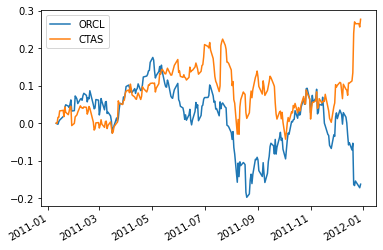

In [108]:
df = chants.get_data(['ORCL','CTAS'],dates1)
df.dropna(axis=0,inplace=True)
df.drop('SPY',inplace=True,axis=1)
((df/df.iloc[0,:])-1).plot()

In [285]:
df = get_data(['ORCL','CTAS'],dates1)
df.dropna(axis=0,inplace=True)
coint(df) # Nope!

[]